# Практическое задание

<ol>
    <li>Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?</li>
</ol>

## Построение двухслойной нейронный сети для классификации цветков ириса

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.datasets import load_iris

## Шаг 1. Определение функций, которые понадобяться для обучения

In [42]:
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# сигмоида и ее производная
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

## Шаг 2. Подготовка тренировочных данных

In [50]:
iris_data = load_iris()
df_iris = pd.DataFrame(
    data= np.c_[iris_data['data'], iris_data['target']],
    columns= iris_data['feature_names'] + ['target']
)
df_iris['target'] = df_iris['target'].astype('int8')
print(df_iris.head(2))

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   

   target  
0       0  
1       0  


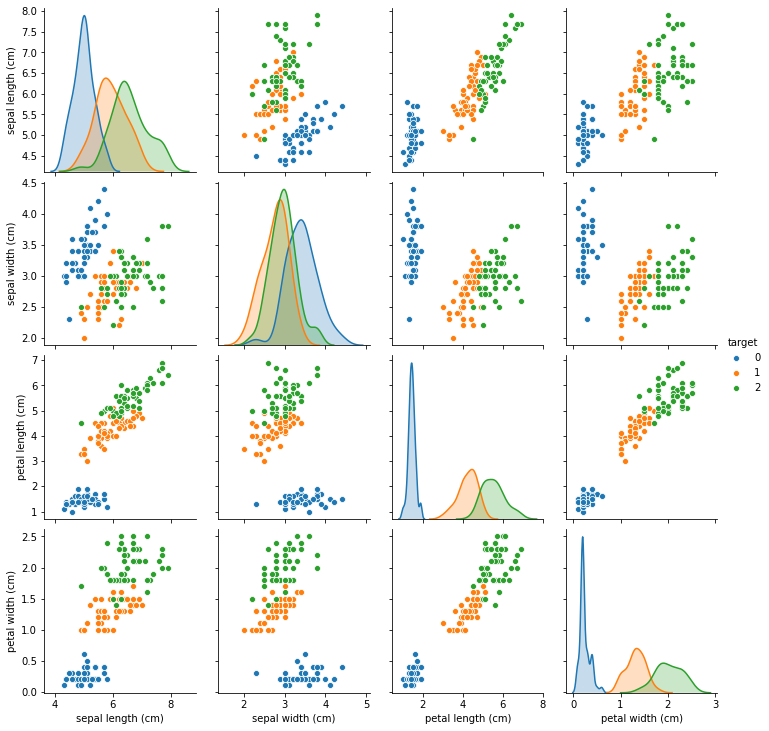

In [54]:
# репрезентация данных в виде графиков
g = sns.pairplot(df_iris, hue="target")

# формирование входных данных
X = df_iris.drop('target', axis=1)
X = normalize(X)

# формирование выходных данных(результатов)
y = df_iris['target']
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Шаг 3. Обученние нейронной сети

In [93]:
def plot(errors, accuracy):
    plt.plot(errors)
    plt.xlabel('Train')
    plt.ylabel('Error')
    plt.title(f"Accuracy " + str(round(accuracy,2)) + "%")
    plt.show()

def train(n_iter: int, params: dict):
    learning_rate: float = params['learning_rate']
    epochs: int = params['epochs']

    errors_all: list = list()
    accuracy_all: list = list()

    for iter in range(n_iter):
        # случайные веса
        w0 = 2 * np.random.random((4, 5)) - 1 # для входного слоя   - 4 входа, 3 выхода
        w1 = 2 * np.random.random((5, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода

        errors = []
        accuracy = 0

        # процесс обучения
        for i in range(epochs + 1):

            # прямое распространение(feed forward)
            layer_0 = X_train
            layer_1 = sigmoid(np.dot(layer_0, w0))
            layer_2 = sigmoid(np.dot(layer_1, w1))

            # обратное распространение(back propagation) с использованием градиентного спуска
            layer_2_error = y_train - layer_2
            layer_2_delta = layer_2_error * sigmoid_deriv(layer_2)
            
            layer_1_error = layer_2_delta.dot(w1.T)
            layer_1_delta = layer_1_error * sigmoid_deriv(layer_1)
            
            w1 += layer_1.T.dot(layer_2_delta) * learning_rate
            w0 += layer_0.T.dot(layer_1_delta) * learning_rate
            
            error = np.mean(np.abs(layer_2_error))
            errors.append(error)
            accuracy = (1 - error) * 100
        
        errors_all.append(errors)
        accuracy_all.append(accuracy)
    
    return errors_all, accuracy_all

## Шаг 4. Демонстрация полученных результатов

#1: {'epochs': 1000, 'learning_rate': 0.1}


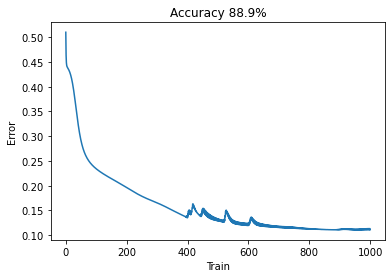

#2: {'epochs': 1000, 'learning_rate': 0.3}


C:\Users\konst\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


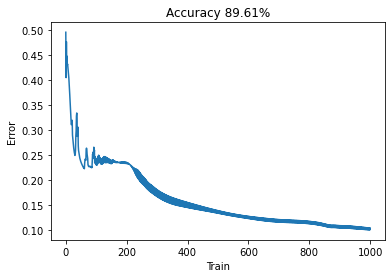

#3: {'epochs': 1000, 'learning_rate': 0.6}


C:\Users\konst\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


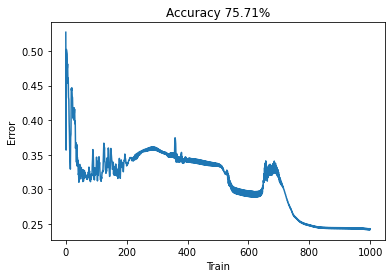

#4: {'epochs': 10000, 'learning_rate': 0.1}


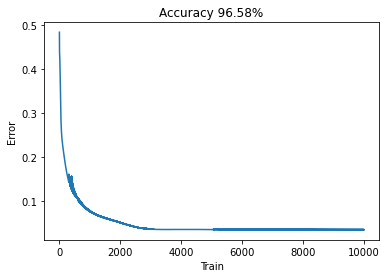

#5: {'epochs': 10000, 'learning_rate': 0.3}


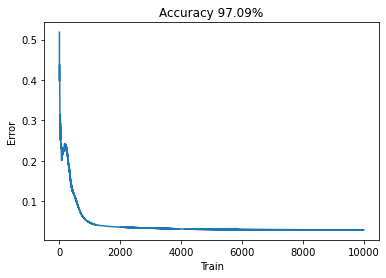

#6: {'epochs': 10000, 'learning_rate': 0.6}


C:\Users\konst\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


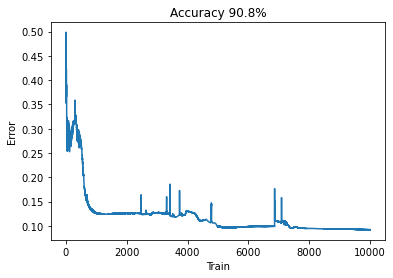

In [96]:
n_iter: int = 5

param_grid = {
    'learning_rate': [0.1, 0.3, 0.6],
    'epochs': [1000, 10000],
}

results: dict = dict()
grid: list = list(ParameterGrid(param_grid))
cnt: int = 0
for params in grid:
    cnt += 1
    print(f'#{cnt}: {params}')
    errors, accuracy = train(n_iter, params)
    results[cnt] = {
        'accuracy': np.mean(accuracy),
        'error': np.mean(errors),
        'params': str(params)
    }
    plot(np.mean(errors, axis=0), np.mean(accuracy, axis=0))


In [97]:
pd.DataFrame.from_dict(results, orient='index').sort_values(by='accuracy', ascending=False)

,accuracy,error,params
5,97.086492,0.042107,"{'epochs': 10000, 'learning_rate': 0.3}"
4,96.579892,0.049147,"{'epochs': 10000, 'learning_rate': 0.1}"
6,90.796124,0.120126,"{'epochs': 10000, 'learning_rate': 0.6}"
2,89.606583,0.160653,"{'epochs': 1000, 'learning_rate': 0.3}"
1,88.896408,0.159616,"{'epochs': 1000, 'learning_rate': 0.1}"
3,75.707934,0.310914,"{'epochs': 1000, 'learning_rate': 0.6}"


## Результаты

* Улучшает точность увеличение колличество эпох
* Высокий learning_rate точность снижает, тк увеличивается шаг и начинаем пропускать локальные минимумы